In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('/home/growlt259/Desktop/Inventory_Prediction_Retail_Market.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Promotion Code,Employee ID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,A,62.0
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,A,46.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,C,13.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,B,22.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,C,79.0


In [3]:
data['sales'] = data['Quantity'] * data['UnitPrice']
data['Date'] = data['InvoiceDate'].dt.date
# data = data[data['Quantity'] > 0]
data.drop(["Promotion Code", "Employee ID"], axis = 1, inplace=True)
data.drop_duplicates(inplace=True)
data.shape

(536643, 10)

In [4]:
desc_to_rmv = ['DOT', 'POST', 'S', 'AMAZONFEE', 'BANK CHARGES', 'CRUK']

In [5]:
data = data[~(data['StockCode'].isin(desc_to_rmv))]
data.shape

(534528, 10)

In [6]:
data = data[~((data['sales'] > 1000) | (data['sales'] < -1000))]

In [7]:
data.set_index('InvoiceDate', inplace=True)
daily_sales = data.sales.resample('D').sum()
daily_sales

InvoiceDate
2010-12-01    54395.50
2010-12-02    41991.32
2010-12-03    42155.90
2010-12-04        0.00
2010-12-05    30559.63
                ...   
2011-12-05    80014.34
2011-12-06    51416.62
2011-12-07    55000.65
2011-12-08    66851.77
2011-12-09    29305.57
Freq: D, Name: sales, Length: 374, dtype: float64

In [9]:
daily_sales = pd.DataFrame(daily_sales)
daily_sales.reset_index(inplace=True)
daily_sales.head()

,InvoiceDate,sales
0,2010-12-01,54395.50
1,2010-12-02,41991.32
2,2010-12-03,42155.90
3,2010-12-04,0.00
4,2010-12-05,30559.63


In [20]:
X = daily_sales[['InvoiceDate', 'sales']].rename(columns={"InvoiceDate": "ds", "sales": "y"})
X['floor'] = 0
X['cap'] = 90000
X.head()

,ds,y,floor,cap
0,2010-12-01,54395.50,0,90000
1,2010-12-02,41991.32,0,90000
2,2010-12-03,42155.90,0,90000
3,2010-12-04,0.00,0,90000
4,2010-12-05,30559.63,0,90000


In [21]:
saturdays = X[X['ds'].dt.weekday == 5][['ds']]
saturdays['holiday'] = 'saturday'
saturdays['lower_window'] = 0
saturdays['upper_window'] = 0

In [22]:
train_size = 344
train, test = X.iloc[:train_size], X.iloc[train_size:]

In [47]:
from prophet import Prophet

model = Prophet(holidays=saturdays)
model.fit(train)

# Make future predictions
future = model.make_future_dataframe(periods=60)
forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

12:39:26 - cmdstanpy - INFO - Chain [1] start processing
12:39:26 - cmdstanpy - INFO - Chain [1] done processing


            ds          yhat    yhat_lower    yhat_upper
0   2010-12-01  24791.343198  12537.204822  37908.723015
1   2010-12-02  29339.240558  15794.023238  42801.705671
2   2010-12-03  21274.689756   8077.381920  35143.277465
3   2010-12-04  -3963.420878 -16828.366664   9948.414848
4   2010-12-05   9764.276629  -3562.790636  23451.054427
..         ...           ...           ...           ...
399 2012-01-04  45595.145481  33012.783420  59253.225518
400 2012-01-05  50233.430684  37136.826570  63788.547882
401 2012-01-06  42259.267723  28552.963349  56659.961441
402 2012-01-07  26251.480866  13610.740977  39423.701652
403 2012-01-08  30929.630280  17319.015232  44111.008964

[404 rows x 4 columns]


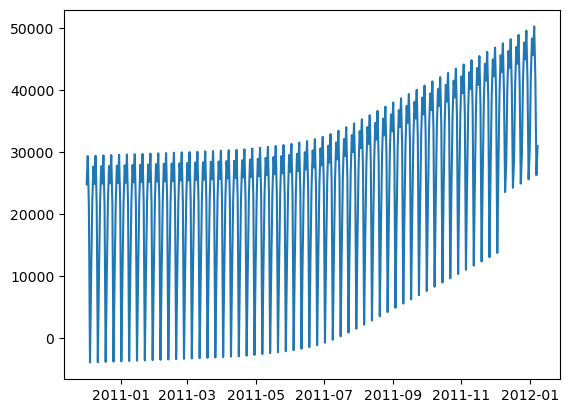

In [48]:
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')

In [49]:
from sklearn.metrics import r2_score
forecast['yhat'] = np.where(forecast['yhat'] < 0, 0, forecast['yhat'])
print(r2_score(X['y'], forecast['yhat']))

ValueError: Found input variables with inconsistent numbers of samples: [374, 404]

In [43]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(X['y'], forecast['yhat']))

7959.657070627486


In [42]:
forecast['yhat']

0      24791.343198
1      29339.240558
2      21274.689756
3          0.000000
4       9764.276629
           ...     
369    39534.695220
370    45579.838292
371    42870.668575
372    47508.953777
373    39534.790817
Name: yhat, Length: 374, dtype: float64

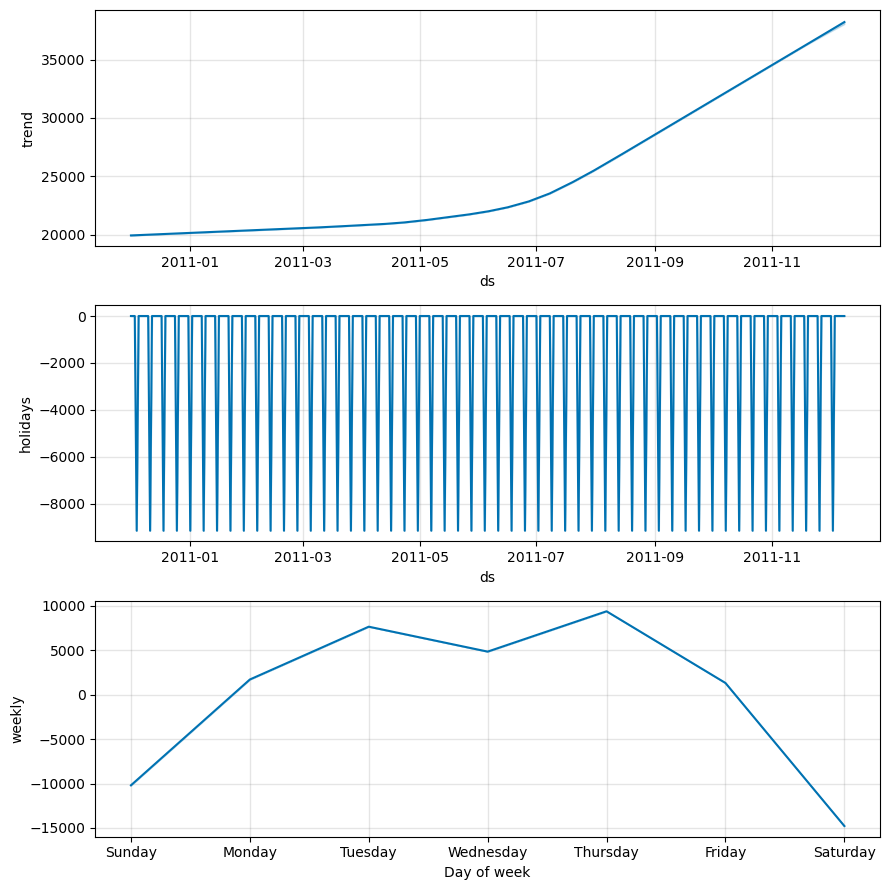

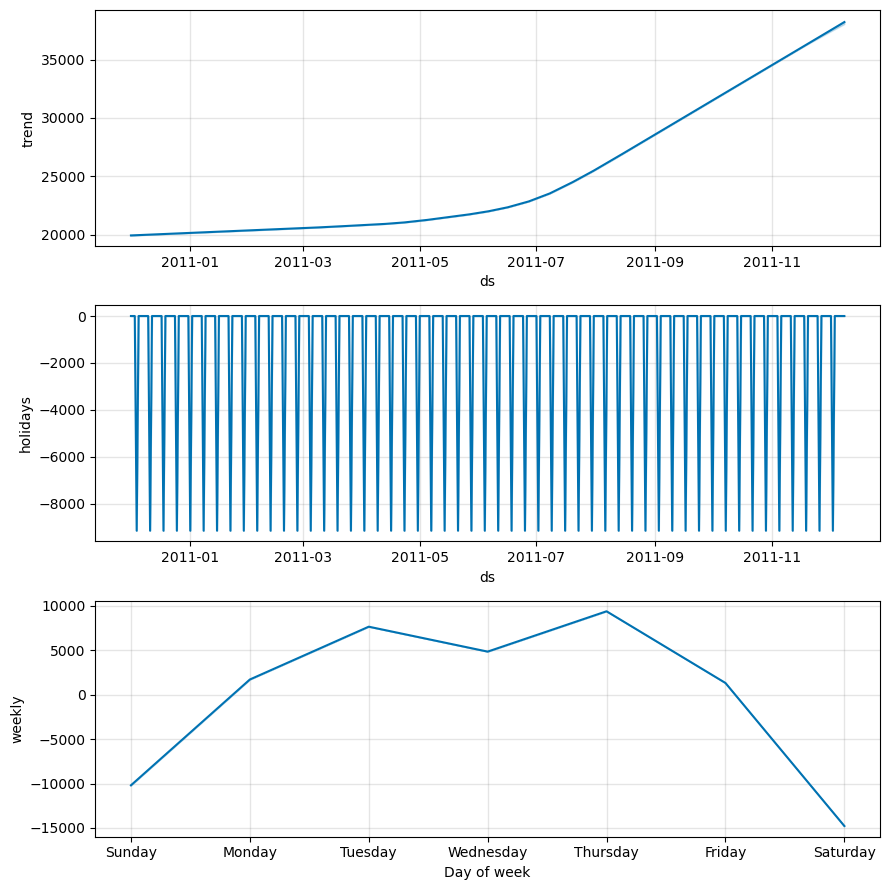

In [37]:
model.plot_components(forecast)

In [39]:
saturdays

,ds,holiday,lower_window,upper_window
3,2010-12-04,saturday,0,0
10,2010-12-11,saturday,0,0
17,2010-12-18,saturday,0,0
24,2010-12-25,saturday,0,0
31,2011-01-01,saturday,0,0
38,2011-01-08,saturday,0,0
45,2011-01-15,saturday,0,0
52,2011-01-22,saturday,0,0
59,2011-01-29,saturday,0,0
66,2011-02-05,saturday,0,0


In [45]:
df = pd.read_excel('/home/growlt259/Desktop/Inventory_Prediction_Retail_Market.xlsx')
df['sales'] = df['Quantity'] * df['UnitPrice']

sales_by_product = df.groupby('StockCode')['sales'].sum()
sorted_sales = sales_by_product.sort_values(ascending=False)

# Select the top 100 products
top_100_products = sorted_sales.head(100)
freq_items = []
for i in top_100_products.index:
    freq_items.append(i)

df = df[df['StockCode'].isin(freq_items)]

In [ ]:
products = df['StockCode'].unique()
# selected_product = st.selectbox('Select a product', products)

# Step 3: Filter the dataset
product_data = data[data['StockCode'] == '85123A']

product_data.set_index('InvoiceDate', inplace=True)
product_data = product_data.sales.resample('D').sum()

product_data = pd.DataFrame(product_data)
product_data.reset_index(inplace=True)

# Step 4: Prepare the data for Prophet
product_data = product_data.rename(columns={'InvoiceDate': 'ds', 'sales': 'y'})

# Step 5: Train the Prophet model
m = Prophet()
m.fit(product_data)

<Axes: >

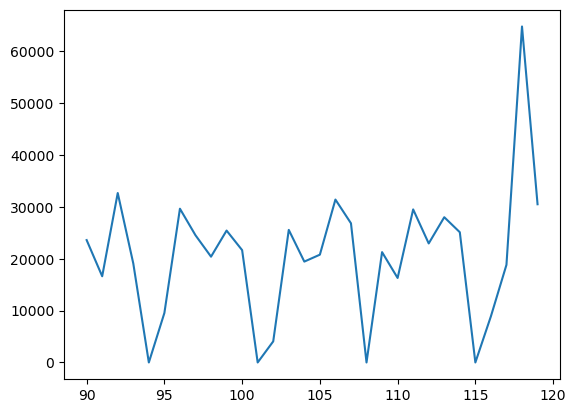

In [56]:
daily_sales['sales'][90:120].plot()